In [1]:
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
import nltk
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import nltk
import itertools
import os

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/rachellai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rachellai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip uninstall numpy gensim --yes
!pip install numpy gensim

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Successfully uninstalled gensim-4.3.1
  Using cached numpy-1.25.2-cp39-cp39-macosx_10_9_x86_64.whl (20.8 MB)
  Using cached gensim-4.3.1-cp39-cp39-macosx_10_9_x86_64.whl (24.0 MB)
  Using cached numpy-1.24.4-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.4 which is incompatible.


In [20]:
filtered_df = pd.read_csv('filtered_df_final.csv')

In [4]:
# Apply ast.literal_eval to convert string to list of dictionaries
filtered_df['filtered_description_tags1'] = filtered_df['filtered_description_tags1'].apply(ast.literal_eval)

# Extract all the words after 'name'
filtered_df['names'] = filtered_df['filtered_description_tags1'].apply(lambda x: [d['name'] for d in x])

In [5]:
# Tokenize the descriptions and create a list of lists
tokenized_descriptions = filtered_df['names'].tolist()

# Create a dictionary from the tokenized descriptions
dictionary = Dictionary(tokenized_descriptions)

# Create a bag-of-words representation of the tokenized descriptions
corpus = [dictionary.doc2bow(text) for text in tokenized_descriptions]

In [6]:
# Perform LDA (first try)
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, alpha=0.01, eta=1, random_state=42)

# Print the topics
for topic in lda_model.print_topics():
    print(topic)

(0, '0.002*"de" + 0.002*"da" + 0.001*"xray" + 0.001*"adsorption" + 0.001*"silica" + 0.001*"ii" + 0.001*"drug" + 0.001*"host" + 0.001*"synthesis" + 0.001*"structure"')
(1, '0.002*"woman" + 0.001*"journal" + 0.001*"us" + 0.001*"vol" + 0.001*"science" + 0.001*"hydrogen" + 0.001*"problem" + 0.001*"group" + 0.001*"output" + 0.001*"school"')
(2, '0.002*"tumor" + 0.002*"life" + 0.002*"strain" + 0.002*"breast" + 0.001*"uptake" + 0.001*"pet" + 0.001*"benign" + 0.001*"climate" + 0.001*"hiv" + 0.001*"patient"')
(3, '0.002*"design" + 0.002*"signal" + 0.001*"world" + 0.001*"aggregate" + 0.001*"oxygen" + 0.001*"derivative" + 0.001*"gain" + 0.001*"research" + 0.001*"type" + 0.001*"energy"')
(4, '0.002*"mass" + 0.002*"equation" + 0.002*"give" + 0.002*"activity" + 0.001*"differential" + 0.001*"coefficient" + 0.001*"part" + 0.001*"aa" + 0.001*"algorithm" + 0.001*"approach"')
(5, '0.002*"cell" + 0.002*"organic" + 0.001*"salinity" + 0.001*"rat" + 0.001*"patient" + 0.001*"theory" + 0.001*"water" + 0.001*"c

In [7]:
#calculating model perplexity
perplexity = lda_model.log_perplexity(corpus)

#printing model perplexity
print(perplexity)

-10.308956385218362


In [8]:
# Use topic coherence to evaluate how good the given topic model is
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Coherence Score: 0.6057437246881342


In [9]:
def topic_diversity(lda_model, top_n):
    # Get the top-N words for each topic
    top_words_per_topic = [lda_model.show_topic(topicid, topn=top_n) for topicid in range(lda_model.num_topics)]

    # Extract word ids
    top_words_per_topic = [[word_id for word_id, _ in topic] for topic in top_words_per_topic]

    # Find unique top words
    unique_top_words = len(np.unique(np.hstack(top_words_per_topic)))

    # Divide by the total number of top words (N * number of topics)
    diversity = unique_top_words / (top_n * lda_model.num_topics)

    return diversity

top_n = 10
diversity = topic_diversity(lda_model, top_n)
print("Topic Diversity:", diversity)

Topic Diversity: 0.93


In [10]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(10))
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(10) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.002726 -0.007754       1        1  11.150024
7     -0.041312  0.028689       2        1  11.087917
4     -0.001799  0.007772       3        1  10.617324
2      0.036521  0.028761       4        1  10.434150
1      0.010749 -0.004535       5        1  10.125300
5      0.004660 -0.008751       6        1  10.019541
3     -0.004620 -0.023282       7        1   9.939874
0     -0.009129 -0.015107       8        1   9.935319
8      0.005248 -0.005045       9        1   9.040322
9      0.002408 -0.000746      10        1   7.650229, topic_info=               Term       Freq      Total Category  logprob  loglift
171         patient  29.000000  29.000000  Default  30.0000  30.0000
2157          woman  15.000000  15.000000  Default  29.0000  29.0000
623   concentration  10.000000  10.000000  Default  28.0000  28.0000
136            cell  23.000000  23.000000  Default  27.0000  27.0000
4253        organic  16.000000  16.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
18            phase   2.663617  10.254439  Topic10  -7.0009   1.2224
66         analysis   2.569635   7.947375  Topic10  -7.0368   1.4414
658         predict   2.534053   8.166075  Topic10  -7.0507   1.4003
300          tissue   2.526246   8.406318  Topic10  -7.0538   1.3682
1393          heart   2.413500   5.880281  Topic10  -7.0995   1.6799

[635 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1705       9  0.609551     0001
15646      4  0.647741     0375
15647      4  0.647741      098
15726      2  0.628358     1016
15502      4  0.647743   105rec
...      ...       ...      ...
5559       9  0.636394       yr
15500      6  0.640733  ziegler
184        3  0.553828      zno
13087      7  0.621901       zr
15677      8  0.656570       zw

[937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 5, 3, 2, 6, 4, 1, 9, 10])

Hyperparameter Tuning

In [11]:
# Define the range of hyperparameter values to explore
alphas = [0.01, 0.1, 1.0]  
betas = [0.01, 0.1, 1.0] 
best_coherence = -1
best_perplexity = float('inf')
best_model = None

#Topics range
min_topics = 2
max_topics = 1000
step_size = 50
topics_range = range(min_topics, max_topics, step_size)


# Perform a grid search over the hyperparameter combinations
for alpha, beta, num_topic in itertools.product(alphas, betas, topics_range):
    # Train the LDA model with current hyperparameters
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, alpha=alpha, eta=beta)

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)

    # Check if the current configuration has the best coherence and perplexity
    if coherence_score > best_coherence and perplexity < best_perplexity:
        best_coherence = coherence_score
        best_perplexity = perplexity
        best_model = lda_model

# Print the best hyperparameters, coherence score, and perplexity
print("Best Hyperparameters:")
print("Alpha:", best_model.alpha)
print("Beta:", best_model.eta)
print("Number of Topics:", best_model.num_topics)
print("Coherence Score:", best_coherence)
print("Perplexity:", best_perplexity)

Best Hyperparameters:
Alpha: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Beta: [0.01 0.01 0.01 ... 0.01 0.01 0.01]
Number of Topics: 52
Coherence Score: 0.7294010569208138
Perplexity: -52.17970952492782


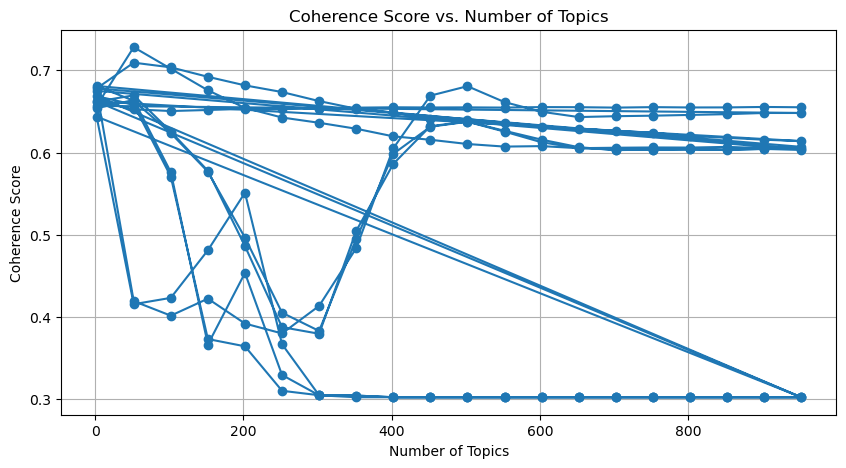

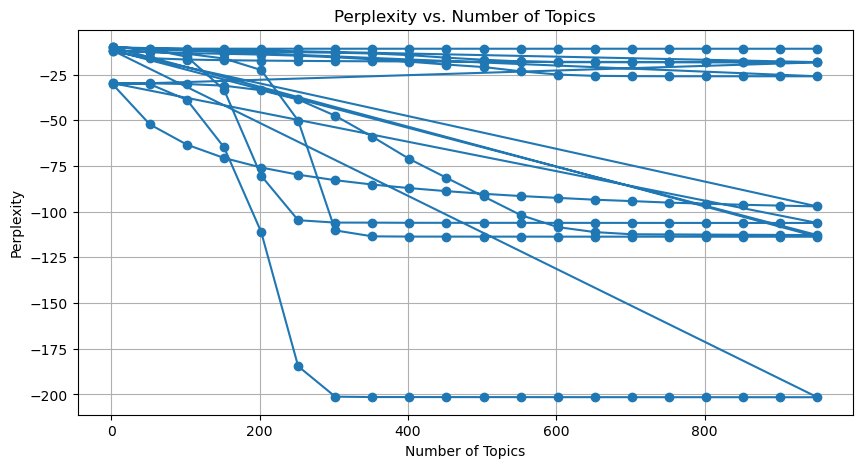

In [23]:
# Lists to store the results
coherence_values = []
perplexity_values = []
num_topics_values = []

# Perform the grid search as before
for alpha, beta, num_topic in itertools.product(alphas, betas, topics_range):
    # Train the LDA model with current hyperparameters
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic, alpha=alpha, eta=beta)

    # Calculate coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_descriptions, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)

    # Append the current results to the lists
    coherence_values.append(coherence_score)
    perplexity_values.append(perplexity)
    num_topics_values.append(num_topic)

    # Check if the current configuration has the best coherence and perplexity
    if coherence_score > best_coherence and perplexity < best_perplexity:
        best_coherence = coherence_score
        best_perplexity = perplexity
        best_model = lda_model
    
# Plotting the Coherence values
plt.figure(figsize=(10,5))
plt.plot(num_topics_values, coherence_values, marker='o')
plt.title('Coherence Score vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid()
plt.show()

# Plotting the Perplexity values
plt.figure(figsize=(10,5))
plt.plot(num_topics_values, perplexity_values, marker='o')
plt.title('Perplexity vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.grid()
plt.show()

In [12]:
# Final LDA Model
lda_model_final = LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_model.num_topics, alpha=best_model.alpha, eta=best_model.eta, random_state=42)

In [13]:
# Assuming lda_model_final is your trained gensim LDA model
top_n = 10
diversity = topic_diversity(lda_model_final, top_n)
print("Topic Diversity:", diversity)

Topic Diversity: 0.6076923076923076


In [14]:
#calculating model perplexity
perplexity = lda_model_final.log_perplexity(corpus)

#printing model perplexity
print(perplexity)

-52.20939807083803


In [15]:
# calculating topic coherence
coherence_model_lda_final = CoherenceModel(model=lda_model_final, texts=tokenized_descriptions, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda_final.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.73440747360716


In [16]:
diversity = topic_diversity(lda_model_final, top_n)
print("Topic Diversity:", diversity)

Topic Diversity: 0.6076923076923076


In [17]:
from pyLDAvis import gensim_models
import os

In [18]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(52))
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, dictionary, mds='mmds')
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(52) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
25    -0.060476 -0.086812       1        1  1.944281
43     0.085496 -0.074042       2        1  1.944037
28    -0.007507  0.049556       3        1  1.940128
17     0.082895  0.063663       4        1  1.940059
34    -0.039719 -0.099253       5        1  1.935511
26    -0.072933 -0.028556       6        1  1.933046
27    -0.086329  0.060987       7        1  1.931931
19     0.050965  0.031469       8        1  1.930840
4     -0.113170 -0.004559       9        1  1.930333
45    -0.051465  0.036038      10        1  1.930029
5     -0.107284  0.069967      11        1  1.929843
14     0.068526  0.079466      12        1  1.929166
47    -0.108974 -0.024836      13        1  1.928958
38     0.057086 -0.058352      14        1  1.928203
48     0.005230 -0.113539      15        1  1.928135
8      0.015154 -0.034974      16        1  1.927985
41     0.092199 -0.106211      17        1  1.927537
36     0.008108 -0.095349      18        1  1.927132
23     0.017756  0.130469      19        1  1.927026
2      0.034549 -0.060751      20        1  1.926636
6     -0.031759  0.000453      21        1  1.926221
7      0.024342  0.091073      22        1  1.925736
39    -0.019282 -0.089954      23        1  1.923983
20    -0.015120  0.110628      24        1  1.923218
44    -0.044584  0.071864      25        1  1.922964
51     0.007131  0.009184      26        1  1.922544
31     0.063457  0.017583      27        1  1.921576
37     0.083854 -0.017059      28        1  1.921514
0      0.111561  0.016226      29        1  1.921149
40     0.036521 -0.024944      30        1  1.920690
10     0.104195  0.046647      31        1  1.920652
30    -0.033908 -0.050634      32        1  1.920605
15     0.029376  0.038807      33        1  1.920598
11     0.009703  0.030741      34        1  1.920506
16     0.129777 -0.023259      35        1  1.920335
24     0.019374  0.001246      36        1  1.920191
32     0.052356  0.095879      37        1  1.918960
18     0.077705 -0.040374      38        1  1.918854
22     0.008624 -0.013879      39        1  1.918564
42    -0.105010  0.019210      40        1  1.918264
50    -0.018953  0.075220      41        1  1.916852
21    -0.061686  0.094736      42        1  1.916443
1     -0.039608 -0.031492      43        1  1.915016
35    -0.109068 -0.077339      44        1  1.914967
29     0.007657  0.072102      45        1  1.914467
13    -0.029491  0.027612      46        1  1.914278
46     0.063961 -0.002550      47        1  1.911963
49    -0.011396 -0.050917      48        1  1.910234
12     0.023485 -0.074510      49        1  1.908663
33    -0.077064  0.020934      50        1  1.907739
9     -0.084802 -0.066973      51        1  1.902660
3     -0.041456 -0.010642      52        1  1.898774, topic_info=             Term        Freq       Total Category  logprob  loglift
4253      organic  106.000000  106.000000  Default  30.0000  30.0000
8171           bi   40.000000   40.000000  Default  29.0000  29.0000
3914         home   38.000000   38.000000  Default  28.0000  28.0000
928   educational   65.000000   65.000000  Default  27.0000  27.0000
2823      trigger   39.000000   39.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1956        tumor    2.606310   83.907233  Topic52  -5.6291   0.4922
249          load    2.135015   55.888442  Topic52  -5.8285   0.6991
136          cell    3.189375  162.832756  Topic52  -5.4272   0.0311
171       patient    3.425058  225.130734  Topic52  -5.3559  -0.2216
1479       design    2.156368   59.216498  Topic52  -5.8186   0.6512

[2362 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1705      1  0.082064  0001
1705      3  0.041032  0001
1705     23  0.041032  0001
1705     25  0.205159  0001
1705     35  0.041032  0001
...     ...       ...   ...
184  